# TF-IDF Cosine Simlarity & Key Words /BERT [Task 2]

This notebook is for task 2 only

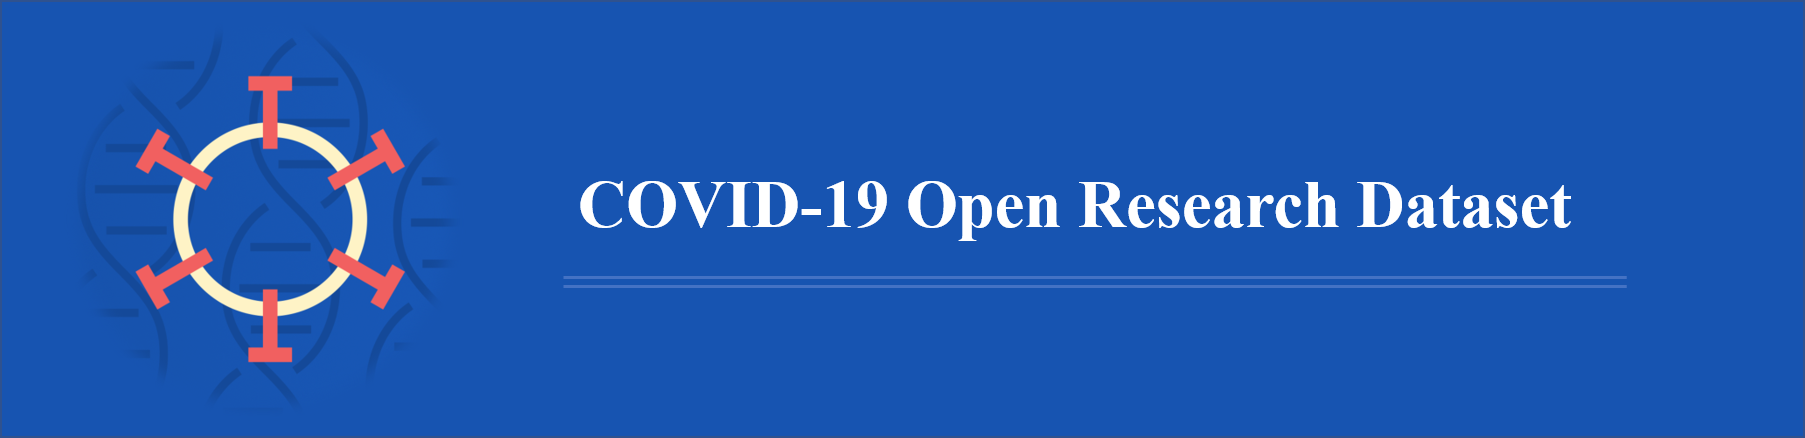

# Introduction
With the COVID-19 keeps ongoing, the number of research publications on COVID-19 is growing fast, making it increasingly difficult for researchers to spot the most relevant findings. This project aims to help the medical community find the information they seek by building data mining and search tools, which can ultimately support the ongoing fight against this pandemic. This notebook contains a basic pipeline of using NLP models to develop answers to high priority scientific questions regarding the COVID-19.

The pipeline in this notebook includes the following steps:
1. Initial Setup
2. Functions
3. Data Preparation
4. Paper Selection
4. Extract Answers for Summary Tables

# Initial Setup

## Load Libraries

In [ ]:
# Import Packages
import os
import re
import nltk
import json
import torch
import nltk.corpus  
import pandas as pd
import numpy as np

from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from fuzzywuzzy import fuzz 
from nltk.stem import PorterStemmer
from datetime import datetime
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

!pip install transformers
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
nltk.download('punkt')
nltk.download('stopwords')

## Functions
### Data Loading
- Function `format_name(author)`, `format_affiliation(affiliation)`, `format_authors(authors, with_affiliation=False)`, `format_body(body_text)`, and `format_bib(bibs)` each converts the paper-related information to standard format.
- Function `load_files(dirname)` loads the papers from json and saves them to a list.
- Function `clean_pdf_files(file_list, keyword_list)` takes a list of file and converts it to a dataframe with cleaned columns.

> The script for loading papers is based on: https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv

### Data Cleaning
- Function `clean_sent(sentence)` cleans the text by lowercasing all words, removing numbers, punctuations, and stopwords, and stemming all words.

### Paper Selection
- Function `calc_simlarity_score(question_list, text_list,threshold=None, top=None)` calculates the similarity score between the TF-IDF matrix of the article and that of questions.
- Function `retrieve_paper(df, dic)` retrieves the information of relevant papers for each question in the specific topic.

> The code for TF-IDF cosine similarity is based on: https://github.com/mbulusu/Duplicate-Document-Detection-Meetup-Presentation

### Extract Answers for Summary Tables
- Function `hasNumbers(inputString)` determines if a string contains any digit, which is used to filter answers to certain questions that expect the answer to be a digit. 
- Function `col_fill(col_questions,col_names,col_for_excerpt,may_not_have_num,index)` fills the summary table with the existing columns from the paper collection(if available).
- Function `answer_question(question, answer_text)` extracts the information with given question.

> The code for Bert is based on: https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-

In [ ]:
# Text Preprocessing `clean_sent()`----------------------------------------------------------------------
porter_stemmer = PorterStemmer()
def clean_sent(sentence):
    """
    Clean the sentence
    :param sentence: text to to be cleaned
    :return: text that has been cleaned
    """
    #nltk.FreqDist(words).most_common(10)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = sentence.split()
    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]
    #words = sentence
    words = [word for word in words if len(word) > 1]
    # Remove numbers
    words = [word for word in words if not word.isnumeric()]
    # Remove punctuation
    words = [word for word in words if word.isalpha()]
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Porter
    words = [porter_stemmer.stem(word) for word in words]
    #fdist = nltk.FreqDist(words_lc)   
    return " ".join(words)


## Data Load----------------------------------------------------------------------
def format_name(author):
    middle_name = " ".join(author['middle'])
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))

    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []

    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)

    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}

    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"

    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []

    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'],
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)

    return raw_files

def clean_pdf_files(file_list, keyword_list):
    nth_paper=0
    cleaned_files=[]
    for file in file_list:
        with open(file) as f:
            file=json.load(f)
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'],
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]
        if(nth_paper%1000)==0:
            print(nth_paper)
        nth_paper=nth_paper+1

        has_keyword = False
        for keyword in keyword_list:
            if keyword in features[5]:
                has_keyword = True
                break
        if has_keyword == True:
            cleaned_files.append(features)
    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text',
                 'bibliography','raw_authors','raw_bibliography']
    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    return clean_df



# BERT----------------------------------------------------------------------
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text,max_length=500
                                )

    # Report how long the input sequence is.
    #print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    
    
    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
            
    s_scores = start_scores.detach().numpy().flatten()
    e_scores = end_scores.detach().numpy().flatten()

    return answer


# Similarity ----------------------------------------------------------------------
def calc_simlarity_score(question_list, text_list,threshold=None, top=None):
    if (threshold==None)  and  (top==None):
        raise ValueError("Parameter `threshold` and `top` cannot both be None")
    dic = {}
    tfidf = TfidfVectorizer()
    corpus_tfidf_matrix = tfidf.fit_transform(text_list)
    ques_tfidf_matrix = tfidf.transform(question_list)
    sim_matrix = cosine_similarity(corpus_tfidf_matrix, ques_tfidf_matrix)
    for ques_idx in range(sim_matrix.shape[1]):
        dic[ques_idx] = []
        if threshold != None:
            if (threshold>1) or (threshold <0):
                raise ValueError("Please enter a value from 0 to 1 for parameter `threshold`")
            for paper_idx in range(sim_matrix.shape[0]):
                score = sim_matrix[paper_idx, ques_idx]
                if score >= threshold:
                    dic[ques_idx].append((paper_idx, score))
            dic[ques_idx]=sorted(dic[ques_idx], key=lambda i: i[1], reverse=True)
        elif top != None:
            top_paper_idx_list = sorted(range(len(sim_matrix[:, ques_idx])), key=lambda i: sim_matrix[:,0][i], reverse=True)[:top]
            dic[ques_idx] = [(top_idx, sim_matrix[top_idx, ques_idx]) for top_idx in top_paper_idx_list]
    return dic, sim_matrix

# Retrieve relevant paper----------------------------------------------------------------------
def retrieve_paper(df, dic):
    df_dic={}
    for ques_idx in dic:
        new_df = df.iloc[[item[0] for item in dic[ques_idx]], :]
        new_df['score'] = [item[1] for item in dic[ques_idx]]
        new_df['question'] = questions[ques_idx]
        df_dic[ques_idx]=new_df.copy()
    return df_dic

# Determine if a string has a value----------------------------------------------------------------------
def hasNumbers(inputString):
     return any(char.isdigit() for char in inputString)


# Data Preparation

## 1. Load data

### Set directory

In [ ]:
# Assign the path of the paper collections provided by Kaggle
path = '/kaggle/input/CORD-19-research-challenge/document_parses/pdf_json'
file_list = [os.path.join(r, file)  for r, _, f in os.walk(path)  for file in f] # Convert the collections to a list

### Load relevant papers
* Load the papers and related information to the data structure.
* Filter the papers to only articles related to COVID-19.

In [ ]:
# Set keywords to filter the papers relevant to COVID-19
keyword_list = ['novel coronavirus', 'novel-coronavirus', 'coronavirus-2019', 
                'sars-cov-2', 'sarscov2', 'covid-19', 'covid19',
                '2019ncov', '2019-ncov', 'wuhan']

# Clean papers（This takes ~15 min）
clean_pdf_df = clean_pdf_files(file_list, keyword_list)

## 2. Combine selected papers with the metadata

In [ ]:
# Append additional info from metadata to main df
metadata = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
clean_pdf_df = clean_pdf_df.merge(metadata[['sha', 'title', 'authors', 'abstract', 'doi', 'publish_time', 'journal']], 
                                  how ='left', left_on='paper_id', right_on='sha')

# Clean columns
clean_pdf_df['title_x'] = clean_pdf_df['title_x'].fillna(clean_pdf_df['title_y'])
clean_pdf_df['authors_x'] = clean_pdf_df['authors_x'].fillna(clean_pdf_df['authors_y'])
clean_pdf_df['abstract_x'] = clean_pdf_df['abstract_x'].fillna(clean_pdf_df['abstract_y'])
clean_pdf_df = clean_pdf_df.drop(['sha', 'title_y', 'authors_y', 'abstract_y'], axis=1)
clean_pdf_df = clean_pdf_df.rename(columns={'title_x': 'title', 'authors_x': 'authors', 'abstract_x': 'abstract'})

## 3. Data preprocessing
* Use lowercase for all content.
* Remove numbers, punctuations, stopwords.
* Remove the commoner morphological and inflexional endings from words in English.


In [ ]:
clean_pdf_df['text_cleaned'] = clean_pdf_df.apply(lambda row: clean_sent(row['text']), axis=1)

### 2.4 (Optional) Save dataframe

In [ ]:
#clean_pdf_df.to_pickle(("./clean_pdf_df.pkl"))
#clean_pdf_df=pd.read_pickle("/kaggle/input/clean-pdf-folder/clean_pdf_df.pkl")

In [ ]:
clean_pdf_df.shape

In [ ]:
clean_pdf_df.head()

# Paper selection
The relevant papers for each question are selected by calculating the cosine similarity score based on the TF-IDF pair of articles and questions. 

TF-IDF is a statistical measure that evaluates how important a word is to a document when compared against the other document in the corpus. In this project, both articles and questions are converted to TF-IDF matrix so that the information can be captured with fewer words and can be used for calculation.

Cosine similarity is a commonly used metric to measure the similarity between two vectors by taking the dot product divided by the product of two vector’s length. In this project, cosine similarity is used to measure the similarity between the TF-IDF matrix pair of documents and questions. In this way, the level of relevance can be quantified, which ultimately helps us to identify the most relevant papers for each question against more than 6,000 articles.


## 1. Set cleaned text and topic

In [ ]:
text_cleaned = clean_pdf_df['text_cleaned']
path = '/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/2_relevant_factors/'

file_list = sorted(list(Path(path).glob('*.csv')))
questions = [file.name.split(".csv")[0].strip('_') for file in file_list]
questions_cleaned = [clean_sent(ques) for ques in questions]
for i,q in enumerate(questions):
    print("Question" ,i + 1,":",q)

## 2. Build table structures with given target tables

In [ ]:
table_cols_dic={}
table_dic={}
target_table_dic={}
for i,file in enumerate(file_list):
    df=pd.read_csv(file)
    cols=list(df.columns)
    table_cols_dic[i]=cols[1:]
    table_dic[i]=df
    target_table_dic[i]=pd.DataFrame(columns=cols)
[print(table_cols_dic[key]) for key in table_cols_dic.keys()]

## 3. Select relevant papers by TF-IDF cosine similarity

In [ ]:
# Select relevant paper to 
dic, sim_matrix = calc_simlarity_score(questions_cleaned, text_cleaned, threshold=0.15)
relevant_paper_dic = retrieve_paper(clean_pdf_df, dic)

In [ ]:
relevant_paper_dic[4].head()

## 4. Add common columns to all summary tables

In [ ]:
for key in target_table_dic.keys():
    target_table_dic[key][['Date', 'Study', 'Journal']]=relevant_paper_dic[key][['publish_time', 'title', 'journal']]
    target_table_dic[key]['Study Link'] = "https://doi.org/" + relevant_paper_dic[key]['doi']
    relevant_paper_dic[key]=relevant_paper_dic[key].reset_index(drop=True)
    target_table_dic[key]=target_table_dic[key].reset_index(drop=True)
    target_table_dic[key]['Added on'] = "10-Jun-2020"

Check for the number of relevant papers for each questions

In [ ]:
for k,v in target_table_dic.items():
    print(k, ':', v.shape[0])

In [ ]:
target_table_dic[1].head()

# Extract Answers for Summary Tables

## Question: "Effectiveness of school distancing" `index: 4`

In [ ]:
# question index
index=4
questions[index]

In [ ]:
# use key word to locate all key sentences and then use BERT to find out the question answers
question = "Effectiveness of school distancing?"
excerpt_list=[]
question_factor = 'what are the factors of school distancing?'
factor_list = []
measure_evidnc_list = []
measure_country_list = []
measure_timeline_list = []
study_type_list = []
question_study = "What is the study type or article research type like Systematic review, meta-analysis, Prospective observational study, Retrospective observational study, Observational study, Cross-sectional study, Case series, Expert review, Editorial, Simulation, or not found?"
question_measure_country = 'which country take measure on school distancing?'
question_measure_timeline = 'what timeline did they take measure on school distancing'


for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = row['text'].split('. ')
    
    # Find relevant sentences
    relevant_sent_list = [sent for sent in sent_list if ( ('school' in sent.lower()) & ('distance' in sent.lower()) ) 
                          or ('effective' in sent.lower()) or ('factors' in sent.lower()) 
                          or ('timeline' in sent.lower()) or (('countries' in sent.lower()) or ('country' in sent.lower())) 
                          or ('measure' in sent.lower())
                          or ( ('study' in sent.lower()) & ('type' in sent.lower()) )]
    
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
    # run BERT on joined excerpt to get answer
    if excerpt_string != '':
        factor_ans = answer_question(question_factor, excerpt_string)
        measure_country_ans = answer_question(question_measure_country, excerpt_string)
        measure_timeline_ans = answer_question(question_measure_timeline, excerpt_string)
        study_ans = answer_question(question_study, excerpt_string)
        if not hasNumbers(measure_timeline_ans):
            measure_country_ans=''
        
        for a in [factor_ans, measure_country_ans,measure_timeline_ans,study_ans]:
            if ("[CLS]" in a) or ('[SEP]' in a):
                a = ""
            
    else:
        factor_ans = ''
        measure_country_ans = ''
        measure_timeline_ans = ''
        study_ans = ''
        
    # Save measure_factor to list
    factor_list.append(factor_ans)
    measure_country_list.append(measure_country_ans) # answer for measure of countries
    measure_timeline_list.append(measure_timeline_ans) # answer for measure of timeline
    study_type_list.append(study_ans)                          
    
target_table_dic[index]["Excerpt"]=excerpt_list
target_table_dic[index]['Factors'] = factor_list

for i,j in zip(measure_country_list,measure_timeline_list):
    measure_evidnc_list.append((i,j))
    
target_table_dic[index]['Measure of Evidence'] = measure_evidnc_list


In [ ]:
target_table_dic[index]

In [ ]:
df1 = target_table_dic[index]
df1.head()

In [ ]:
df1.to_csv('./target_table_2_q1.csv')

In [ ]:
##new method to select study type and measure of evidence: select top 5 most related sentence for a specific question, and then find out the answer in the top 5 sentences
target_table_dic_2 = target_table_dic
def col_fill(col_questions,col_names,col_for_excerpt,may_not_have_num,index):
    """
    Get answers for multiple columns and append them back to target table (target_table_dic[index])
    :param col_questions: a list of string - questions, each corresponds to a specific column (excluding excerpt)
    :param col_names: a list of string - columns names in target table to which col_questions correspond
    :param col_for_excerpt: string - the most important question in col_questions, on which excerpt based
    :param may_not_have_num: a list of string - column names in col_names, to indicate columns that may not have digits (columns that not put in this list must have digits in its answer)
    :param index: question number in this task
    :return: target_table_dic[index] with content filled in designated columns 
    """
    col_questions_cleaned = [clean_sent(ques) for ques in col_questions]
    # go through papers
    for i in tqdm(range(relevant_paper_dic[index].shape[0])):
        #get sentences of each paper, preprocess it
        paper_sent=relevant_paper_dic[index].text[i].split(". ")
        cleaned_paper_sent = [clean_sent(t) for t in paper_sent]
        for num,q in enumerate(col_questions_cleaned):
            # define questions
            col_name=col_names[num]
            full_question= col_questions[num]
            # extract top 3 sentences/paper for a specific questions, join them together as a string
            lis=[]
            for sent in cleaned_paper_sent:
                lis.append(fuzz.ratio(q,sent) )
            top_3_idx = [item[0] for item in sorted(enumerate(lis), key=lambda x: x[1],reverse=True)[0:5]]
            #max_idx=max(enumerate(lis), key=lambda x: x[1])[0]
            string ='; \n'.join([paper_sent[idx] for idx in top_3_idx])
            # Get answers, delete those without a number 
            answer=answer_question(full_question,string)        
            if (not hasNumbers(answer)) and (col_name not in may_not_have_num):
                answer="" 
            if "[CLS]" in answer:
                answer = ""
            if "[SEP]" in answer:
                answer = ""
            target_table_dic_2[index].loc[i,col_name]=answer
            #  Exerpt answer extract
            if col_name == col_for_excerpt:
                excerpt_ans=string
                for idx in top_3_idx:
                    if (answer in paper_sent[idx]) and (answer!=""):
                        excerpt_ans=paper_sent[idx]
                target_table_dic_2[index].loc[i,"Excerpt"]=excerpt_ans
    return target_table_dic_2[index]

In [ ]:
col_questions = ['what are the factors of school distancing?',
                 'which country take measure on school distancing?',
                 'what timeline did they take measure on school distancing',
                 "What is the study type or article research type like Systematic review, meta-analysis, Prospective observational study, Retrospective observational study, Observational study, Cross-sectional study, Case series, Expert review, Editorial, Simulation, or not found?"]

col_names=['Factors','Measure_country',"Measure_timeline","Study Type"]
col_for_excerpt='Factors'
may_not_have_num=['Factors','Measure_country',"Study Type"]

target_table_dic_2[index]=col_fill(col_questions,col_names,col_for_excerpt,may_not_have_num,index)

In [ ]:
target_table_dic_2[index]['Measure of Evidence'] = target_table_dic_2[index].apply(lambda x: (x['Measure_country'], x['Measure_timeline']), axis = 1)

In [ ]:
target_table_dic_2[index]

In [ ]:

df2 = target_table_dic_2[index].rename(columns = {'Factors':'Factors_2','Study Type':'Study Type_2','Measure of Evidence':'Measure of Evidence_2'})
df2.to_csv('./target_table_2_q1_2.csv')

In [ ]:
tb = pd.read_csv('../input/output/target_table_2_q1_combined.csv')
tb.shape

In [ ]:
tb

In [ ]:
tb.to_csv('./target_table_2_q1_final_result.csv')

# Conclusion
Here we tackled the question about the effectiveness of school distancing. Two methods are invovled in extracting answers for specific columns: factors, influencial, measure of evidence, study type.

The first method is to use key word to locate key sentences, and then apply BERT model on the key sentences to find out specific answers. The second method is similar to the first one, it is to extract top 3 sentences/paper for a specific questions, join them together as a string, and then apply BERT model to find out answers. 

The first method performs well on the extraction of factors and measure of evidence, while the second model has better performs on the extraction of study type, and some of the results for measure of evidence can be a complement to the first method result. So the final result 'tb' is a combination of method 1 and method 2 with certain human adjustments. 

From the table we can see that most of the school distancing methods involves school closure, from care center to universities, and has a influencial impact on reducing the virus transmission, especially when combined with other social distancing methods.


# Contact
* Kaitan Sun, kaitan9095@gmail.com
* Jiangxue Han, jxhan0317@gmail.com
* Richard Luo, ruize.luo@outlook.com
* Hanying Gan, hanying.gan@outlook.com


# Reference
- The code for paper loading functions is based on: https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv
- The code for TF-IDF cosine similarity is based on: https://github.com/mbulusu/Duplicate-Document-Detection-Meetup-Presentation
- The code for Bert is based on: https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-